In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [4]:
def extract_durations(r_peaks_i_array, r_valleys_i_array, r_peaks_a_array, r_valleys_a_array, thr=0.2, thr_last=0.1):
    ref = np.concatenate((r_peaks_a_array, r_valleys_a_array), axis=1)
    test = np.concatenate((r_peaks_i_array, r_valleys_i_array), axis=1)
    
    starts = []
    ends = []
    durations = []
    
    for i in range(test.shape[0]):
        current_test = test[i]
        current_ref = ref[i]
        
        # Calculate start and end
        start_r = np.nanmin(current_test) if np.any(~np.isnan(current_test)) else 0
        end_r = np.nanmax(current_test) if np.any(~np.isnan(current_test)) else 0
        
        # Check the amplitude of the first point
        first_point_index = np.nanargmin(current_test) if np.any(~np.isnan(current_test)) else 0
        first_point_amplitude = current_ref[first_point_index]
        
        if abs(first_point_amplitude) > thr:
            start_r = 0
            
            # Initialize a flag for the second peak
            second_peak_found = False
            
            # Iterate through amplitudes after the first point
            for j in range(first_point_index + 1, len(current_ref)):
                amplitude_diff = abs(current_ref[j] - current_ref[j-1])
                
                if not second_peak_found:
                    # Allow finding the second peak
                    if amplitude_diff > thr_last:
                        second_peak_found = True
                else:
                    # If second peak is found, ignore small amplitude differences
                    if amplitude_diff < thr_last:
                        current_test[j] = np.nan  # Ignore this point in min/max calculation
        
            # Re-calculate end based on the modified test array
            end_r = np.nanmax(current_test) if np.any(~np.isnan(current_test)) else 0
        
        # Calculate duration
        dur_r = end_r - start_r
        
        starts.append(start_r)
        ends.append(end_r)
        durations.append(dur_r)
    
    return np.array(starts), np.array(ends), np.array(durations)




In [5]:
def reshape_feature_array(feature_vector_array):
    """
    Reshape the feature vector array into a specified shape and extract sub-arrays.

    Parameters:
    - feature_vector_array: numpy.ndarray, the array to be reshaped.

    Returns:
    - reshaped_array: numpy.ndarray, the reshaped array.
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: separate sub-arrays.
    """
    max_n = int(feature_vector_array.shape[1] / 4)

    # Reshape the array
    reshaped_array = feature_vector_array.reshape(feature_vector_array.shape[0], 4, max_n)

    # Extract sub-arrays
    peaks_a_array = reshaped_array[:, 0, :]
    peaks_i_array = reshaped_array[:, 1, :]
    valleys_a_array = reshaped_array[:, 2, :]
    valleys_i_array = reshaped_array[:, 3, :]

    print(f"Reshaped array shape: {reshaped_array.shape}")

    return reshaped_array, peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array

In [6]:
sns.set_theme(style="white", palette="pastel")

## Load data

In [7]:
master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/testdata/Raw_Data/240423_f0')]

In [8]:
fish= 0
fish_id =  fish_paths[fish].name
exp_name = Path(fish_paths[fish]).parts[-2]
exp_name = 'testfish'
fish_id, exp_name


('240423_f0', 'testfish')

In [9]:
out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')
save_data_path = out_path

In [10]:
t_feature_vector_array = fl.load(save_data_path/ '{}_t_feature_vector_array.h5'.format(fish_id))
l_feature_vector_array = fl.load(save_data_path/ '{}_l_feature_vector_array.h5'.format(fish_id))
r_feature_vector_array = fl.load(save_data_path/ '{}_r_feature_vector_array.h5'.format(fish_id))

In [11]:
### tail, left fin, right fin

traces =  fl.load(out_path / '{}_tensor.h5'.format(fish_id))
traces.shape

(500, 3, 50)

#### Reshape data

In [12]:
max_n = int(l_feature_vector_array.shape[1]/4)
max_n

9

In [13]:
t_reshaped_array, t_peaks_a_array, t_peaks_i_array, t_valleys_a_array, t_valleys_i_array = reshape_feature_array(t_feature_vector_array)
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(l_feature_vector_array)
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(r_feature_vector_array)


Reshaped array shape: (500, 4, 9)
Reshaped array shape: (500, 4, 9)
Reshaped array shape: (500, 4, 9)


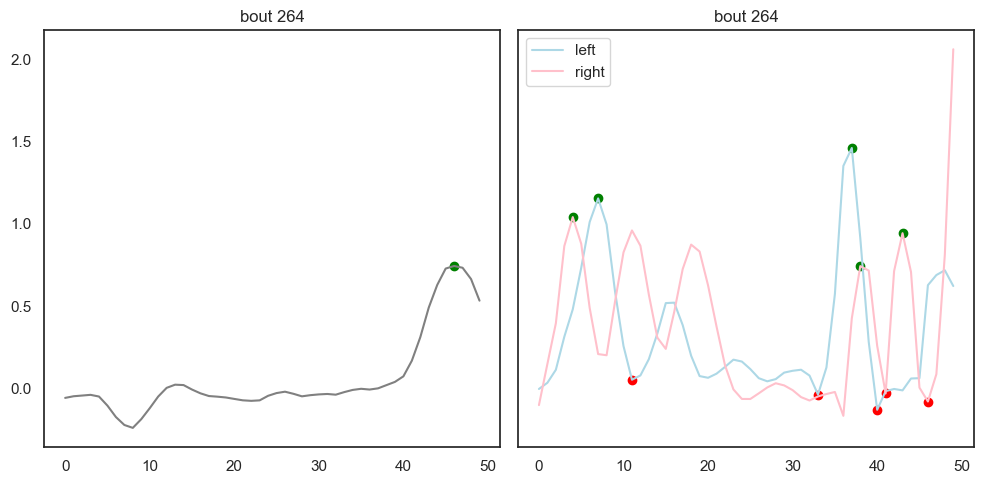

In [14]:
bout = np.random.randint(0,traces.shape[0])

fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].plot(traces[bout,0,:], c='gray', label='tail')
axes[0].scatter(t_peaks_i_array[bout], t_peaks_a_array[bout], c='green')
axes[0].scatter(t_valleys_i_array[bout], t_valleys_a_array[bout], c='red')
axes[0].set_title('bout {}'.format(bout))

axes[1].plot(traces[bout,1,:]*-1, c='lightblue', label='left')
axes[1].scatter(l_peaks_i_array[bout], l_peaks_a_array[bout], c='green')
axes[1].scatter(l_valleys_i_array[bout], l_valleys_a_array[bout], c='red')

axes[1].plot(traces[bout,2,:], c='pink', label='right')
axes[1].scatter(r_peaks_i_array[bout],r_peaks_a_array[bout], c='green')
axes[1].scatter(r_valleys_i_array[bout], r_valleys_a_array[bout], c='red')
axes[1].set_title('bout {}'.format(bout))

plt.legend()
plt.tight_layout()

### Extract duration

In [17]:
start_t, end_t, duration_t = extract_durations(t_peaks_i_array, t_valleys_i_array, t_peaks_a_array, t_valleys_a_array)
start_l, end_l, duration_l = extract_durations(l_peaks_i_array, l_valleys_i_array, l_peaks_a_array, l_valleys_a_array)
start_r, end_r, duration_r = extract_durations(r_peaks_i_array, r_valleys_i_array, r_peaks_a_array, r_valleys_a_array)

0.0 15.0


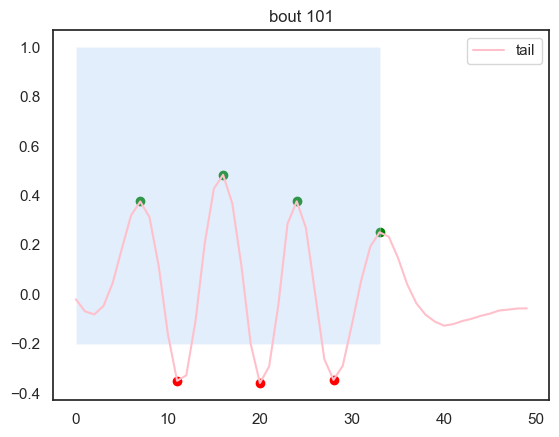

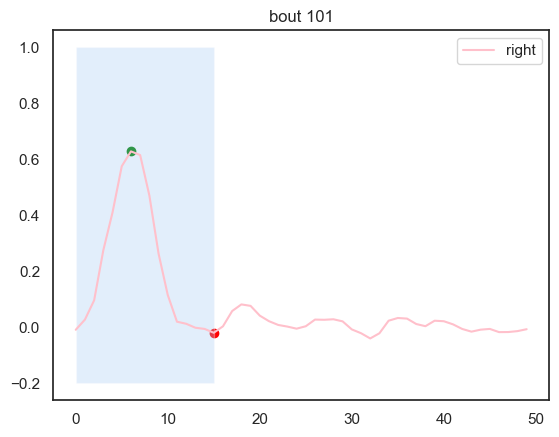

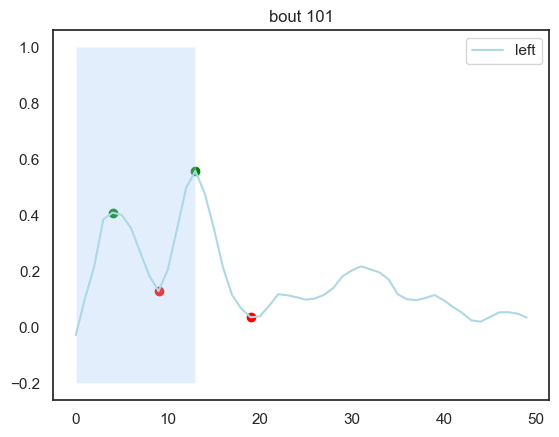

In [22]:
bout =  np.random.randint(0,traces.shape[0])
print (start_r[bout], end_r[bout])

plt.figure()
plt.plot(traces[bout,0,:], c='pink', label='tail')
plt.scatter(t_peaks_i_array[bout],t_peaks_a_array[bout], c='green')
plt.scatter(t_valleys_i_array[bout], t_valleys_a_array[bout], c='red')
plt.fill_between([start_t[bout], end_t[bout]], y1=1, y2=-0.2, alpha=0.3)
plt.title('bout {}'.format(bout))
plt.legend()

plt.figure()
plt.plot(traces[bout,2,:], c='pink', label='right')
plt.scatter(r_peaks_i_array[bout],r_peaks_a_array[bout], c='green')
plt.scatter(r_valleys_i_array[bout], r_valleys_a_array[bout], c='red')
plt.fill_between([start_r[bout], end_r[bout]], y1=1, y2=-0.2, alpha=0.3)
plt.title('bout {}'.format(bout))
plt.legend()

plt.figure()
plt.plot(traces[bout,1,:]*-1, c='lightblue', label='left')
plt.scatter(l_peaks_i_array[bout],l_peaks_a_array[bout], c='green')
plt.scatter(l_valleys_i_array[bout], l_valleys_a_array[bout], c='red')
plt.fill_between([start_l[bout], end_l[bout]], y1=1, y2=-0.2, alpha=0.3)
plt.title('bout {}'.format(bout))
plt.legend()

### Save durations

In [20]:
fl.save(save_data_path / '{}_t_durations.h5'.format(fish_id), [duration_t, start_t, end_t]) 
fl.save(save_data_path / '{}_l_durations.h5'.format(fish_id), [duration_l, start_l, end_l]) 
fl.save(save_data_path / '{}_r_durations.h5'.format(fish_id), [duration_r, start_r, end_r])